In [17]:
import pandas as pd

df = pd.read_csv("/content/interpolated_education_dataset.csv")

# target countries
target_countries = ["Bangladesh", "United States", "Niger", "South Korea", "Norway"]

# filtering and sorting
df_filtered = df[df["Country"].isin(target_countries)].sort_values(by=["Country", "Year"]).reset_index(drop=True)

exog_vars = [
    "GDP_Per_Capita",
    "Homicide_Rate",
    "Avg_Yrs_Education",
    "Infant_Mortality",
    "Life_Expectancy"
]
# checking for missing values in exogenous variables
missing_check = df_filtered[exog_vars].isnull().sum()
print("Missing values in exogenous variables:\n", missing_check)
exog_vars = [
    "GDP_Per_Capita",
    "Homicide_Rate",
    "Avg_Yrs_Education",
    "Infant_Mortality",
    "Life_Expectancy"
]
# linearly interpolate
for col in exog_vars:
    df_filtered[col] = (
        df_filtered.groupby("Country", group_keys=False)[col]
        .apply(lambda x: x.interpolate(method="linear"))
    )
# check for missing values
print(df_filtered[exog_vars].isnull().sum())

Missing values in exogenous variables:
 GDP_Per_Capita        0
Homicide_Rate        10
Avg_Yrs_Education     0
Infant_Mortality      5
Life_Expectancy       0
dtype: int64
GDP_Per_Capita       0
Homicide_Rate        0
Avg_Yrs_Education    0
Infant_Mortality     0
Life_Expectancy      0
dtype: int64


In [18]:
# ADF TEST
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

fertility_series = df_filtered["Fertility_Rate"]
result = adfuller(fertility_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.773415
p-value: 0.393738
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [19]:
# Needs differencing, so need to do ARIMAX(1,1,1)
from statsmodels.tsa.statespace.sarimax import SARIMAX

exog_vars = ["GDP_Per_Capita", "Homicide_Rate", "Avg_Yrs_Education", "Infant_Mortality", "Life_Expectancy"]
models = {}
forecasts = []

# forecasting
future_years = list(range(df_filtered["Year"].max() + 1, df_filtered["Year"].max() + 11))

# ARIMAX for each country
for country in target_countries:
    cdf = df_filtered[df_filtered["Country"] == country].dropna(subset=exog_vars)

    if len(cdf) > 10:
        model = SARIMAX(
            cdf["Fertility_Rate"],
            order=(1,1,1),
            exog=cdf[exog_vars],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        models[country] = results

        # using the last row's exog values for forecasting
        future_exog = pd.DataFrame([cdf[exog_vars].iloc[-1].values] * 10, columns=exog_vars)
        forecast = results.get_forecast(steps=10, exog=future_exog)

        forecast_df = pd.DataFrame({
            "Country": country,
            "Year": future_years,
            "ARIMAX_Forecast": forecast.predicted_mean
        })
        forecasts.append(forecast_df)

# combining all forecast data
arimax_forecasts = pd.concat(forecasts, ignore_index=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

In [21]:
# UN projection dataset
un_data = pd.read_csv("/content/fertility-rate-with-projections.csv")

# clean and rename the columns for ease
un_data = un_data.rename(columns={
    "Entity": "Country",
    "Fertility rate - Sex: all - Age: all - Variant: estimates": "UN_Estimates",
    "Fertility rate - Sex: all - Age: all - Variant: medium": "UN_Projections"
})

# filtering relevant countries and years
future_years = list(range(2024, 2034))
un_projection_df = un_data[
    (un_data["Country"].isin(target_countries)) &
    (un_data["Year"].isin(future_years))
][["Country", "Year", "UN_Projections"]].dropna()

In [22]:
# merge ARIMAX and UN projections
comparison_df = pd.merge(arimax_forecasts, un_projection_df, on=["Country", "Year"], how="inner")

# Calculate forecast difference
comparison_df["Difference"] = comparison_df["ARIMAX_Forecast"] - comparison_df["UN_Projections"]

# errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# overall metrics
y_true = comparison_df["UN_Projections"]
y_pred = comparison_df["ARIMAX_Forecast"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.1646
RMSE: 0.2257


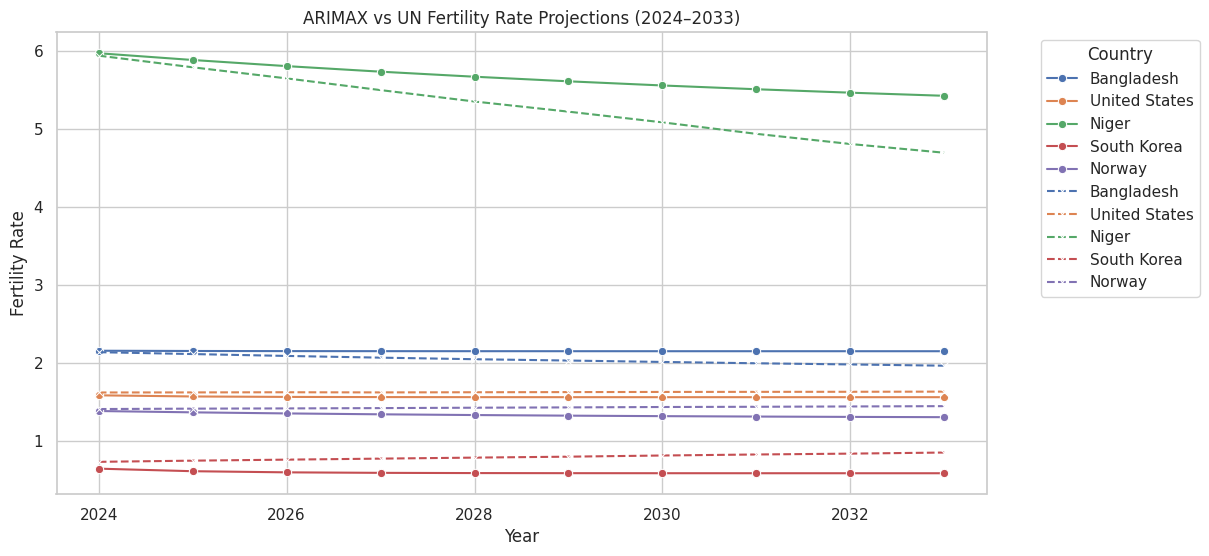

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# ARIMAX forecasts
sns.lineplot(
    data=comparison_df,
    x="Year", y="ARIMAX_Forecast",
    hue="Country",
    marker="o",
    linestyle="-"
)

# UN projections
sns.lineplot(
    data=comparison_df,
    x="Year", y="UN_Projections",
    hue="Country",
    marker="x",
    linestyle="--"
)

# put it together
plt.title("ARIMAX vs UN Fertility Rate Projections (2024–2033)")
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
